In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow

In [2]:
df = pd.read_csv(r'C:\Users\dgmur\OneDrive\Desktop\data science projects 2024\bbc_data.csv')
df.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    2225 non-null   object
 1   labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [4]:
df.isnull().sum()

data      0
labels    0
dtype: int64

In [5]:
df['labels'].value_counts()

labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='labels'>

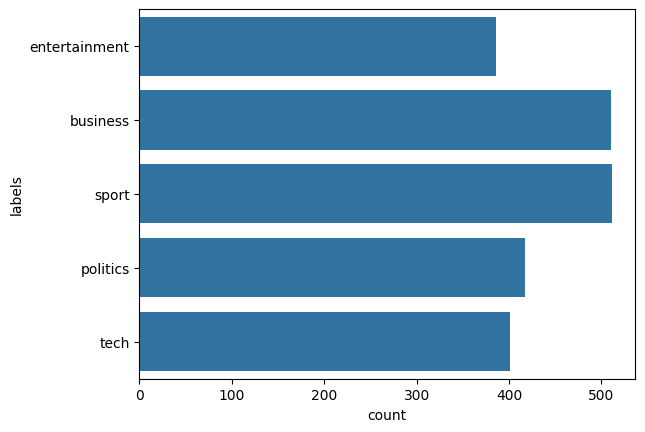

In [6]:
sns.countplot(df['labels'])

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['data'])
vocab_size = len(tokenizer.word_counts)


In [9]:
word2index = tokenizer.word_index
index2word = {v:k for (k,v) in word2index.items()}

In [10]:
print(vocab_size)

30935


In [11]:
import numpy as np

In [12]:
sequence_lengths = np.array([len(s.split()) for s in list(df['data'])])

In [13]:
sequence_lengths

array([378, 838, 358, ..., 293, 332, 162])

In [14]:
print([(p, np.percentile(sequence_lengths, p)) for p in [75, 80, 90, 95, 99, 100]])

[(75, 472.0), (80, 505.0), (90, 616.6000000000001), (95, 729.0), (99, 1002.5199999999995), (100, 4432.0)]


In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
max_len = 400
sentences_as_vector = tokenizer.texts_to_sequences(df['data'])
sentence_as_vectors = pad_sequences(sentences_as_vector, maxlen= max_len)
# Encode string labels to integers
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(df['labels'])




In [17]:
sentence_as_vectors

array([[    0,     0,     0, ...,     9,    15,   114],
       [ 2740,    41,   560, ...,   134,   155,    40],
       [    0,     0,     0, ...,    10,   531,   967],
       ...,
       [    0,     0,     0, ...,  4984,   778,  2359],
       [    0,     0,     0, ..., 19410,     4,  4065],
       [    0,     0,     0, ...,   739,     6,   244]])

In [18]:
integer_encoded_labels

array([1, 1, 1, ..., 4, 4, 4])

In [19]:
dataset = tensorflow.data.Dataset.from_tensor_slices((sentence_as_vectors, integer_encoded_labels))

In [20]:
dataset.shuffle(1000)
test_size = len(df['data']) // 4
val_size = (len(df['data']) - test_size)//20
test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)
batch_size = 64
train_dataset = train_dataset.batch(batch_size)
val_dataset =val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [21]:
from tensorflow.keras.layers import Embedding

In [22]:
input_1 = Input(shape = (max_len,))
x = Embedding(vocab_size+1, max_len)(input_1)
x = LSTM(50)(x)
x = Dense(64, activation = 'relu')(x)
output1 = Dense(5, activation = 'softmax')(x)
model_1 = Model(inputs = input_1, outputs = output1)
model_1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400)]             0         
                                                                 
 embedding (Embedding)       (None, 400, 400)          12374400  
                                                                 
 lstm (LSTM)                 (None, 50)                90200     
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 12468189 (47.56 MB)
Trainable params: 12468189 (47.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model_1.fit(train_dataset, validation_data=val_dataset, epochs=25)

Epoch 1/25
25/25 [==============================] - 13s 474ms/step - loss: 1.6805 - accuracy: 0.1129 - val_loss: 1.5775 - val_accuracy: 0.0000e+00
Epoch 2/25
25/25 [==============================] - 13s 506ms/step - loss: 1.5752 - accuracy: 0.2686 - val_loss: 1.6320 - val_accuracy: 0.0000e+00
Epoch 3/25
25/25 [==============================] - 13s 526ms/step - loss: 1.4691 - accuracy: 0.3272 - val_loss: 1.7861 - val_accuracy: 0.0000e+00
Epoch 4/25
25/25 [==============================] - 12s 483ms/step - loss: 1.2350 - accuracy: 0.5177 - val_loss: 1.8419 - val_accuracy: 0.0361
Epoch 5/25
25/25 [==============================] - 13s 523ms/step - loss: 0.9227 - accuracy: 0.7484 - val_loss: 2.4109 - val_accuracy: 0.0361
Epoch 6/25
25/25 [==============================] - 13s 513ms/step - loss: 0.5550 - accuracy: 0.8695 - val_loss: 1.9661 - val_accuracy: 0.1566
Epoch 7/25
25/25 [==============================] - 13s 523ms/step - loss: 0.2216 - accuracy: 0.9578 - val_loss: 1.4911 - val_accu

In [24]:
labels, predictions = [], []
index2word[0] = 'PAD'
is_first_batch_true = True
for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = model_1.predict(inputs_b)
    predictions.extend(np.argmax(pred_batch, axis=1).tolist())
    labels.extend(labels_b.numpy().tolist())  # Convert to list of scalars
    
    # Example output for the first batch
    if is_first_batch_true:
        for rid in range(inputs_b.shape[0]):
            words = [index2word[idx] for idx in inputs_b[rid].numpy()]
            words = [w for w in words if w != 'PAD']
            sentence = " ".join(words)
            print(f"{labels[rid]}\t{predictions[rid]}\t{sentence}")
        is_first_batch_true = False
print('accuracy_score:', accuracy_score(labels, predictions))

# Now `labels` and `predictions` should be lists of integers


2/2 [==============================] - 0s 117ms/step
1	2	musicians to tackle us red tape musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic a singer hoping to perform in the us can expect to pay 1 300 xc2xa3680 simply for obtaining a visa groups including the musicians union are calling for an end to the raw deal faced by british performers us acts are not faced with comparable expense and bureaucracy when visiting the uk for promotional purposes nigel mccune from the musicians union said british musicians are disadvantaged compared to their us counterparts a sponsor has to make a petition on their behalf which is a form amounting to nearly 30 pages while musicians face tougher regulations than athletes and journalists if you make a mistake on your form you risk a five year ban and thus the ability to further your career says mr mccune the us is the worlds biggest music market which means something ha

In [25]:
input_2 = Input(shape = (max_len,))
x = Embedding(vocab_size+1, max_len)(input_2)
x = LSTM(300)(x)
x = Dropout(0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.3)(x)
output2 = Dense(5, activation = 'softmax')(x)
model_2 = Model(inputs = input_2, outputs = output2)
model_2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 400, 400)          12374400  
                                                                 
 lstm_1 (LSTM)               (None, 300)               841200    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                19264     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [26]:
model_2.fit(train_dataset, validation_data=val_dataset, epochs=25)

Epoch 1/25
25/25 [==============================] - 61s 2s/step - loss: 2.3950 - accuracy: 0.2768 - val_loss: 1.6355 - val_accuracy: 0.0602
Epoch 2/25
25/25 [==============================] - 60s 2s/step - loss: 1.6388 - accuracy: 0.0511 - val_loss: 1.6558 - val_accuracy: 0.0120
Epoch 3/25
25/25 [==============================] - 62s 2s/step - loss: 1.5334 - accuracy: 0.3373 - val_loss: 1.7092 - val_accuracy: 0.0241
Epoch 4/25
25/25 [==============================] - 63s 3s/step - loss: 1.6870 - accuracy: 0.3619 - val_loss: 3.5510 - val_accuracy: 0.0964
Epoch 5/25
25/25 [==============================] - 62s 2s/step - loss: 2.7084 - accuracy: 0.1828 - val_loss: 2.6943 - val_accuracy: 0.0000e+00
Epoch 6/25
25/25 [==============================] - 61s 2s/step - loss: 2.3866 - accuracy: 0.0712 - val_loss: 1.6793 - val_accuracy: 0.0000e+00
Epoch 7/25
25/25 [==============================] - 63s 3s/step - loss: 1.5921 - accuracy: 0.2535 - val_loss: 1.8028 - val_accuracy: 0.0000e+00
Epoch 8/

In [27]:
labels, predictions = [], []
index2word[0] = 'PAD'
is_first_batch_true = True
for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = model_2.predict(inputs_b)
    predictions.extend(np.argmax(pred_batch, axis=1).tolist())
    labels.extend(labels_b.numpy().tolist())  # Convert to list of scalars
    
    # Example output for the first batch
    if is_first_batch_true:
        for rid in range(inputs_b.shape[0]):
            words = [index2word[idx] for idx in inputs_b[rid].numpy()]
            words = [w for w in words if w != 'PAD']
            sentence = " ".join(words)
            print(f"{labels[rid]}\t{predictions[rid]}\t{sentence}")
        is_first_batch_true = False
print('accuracy_score:', accuracy_score(labels, predictions))

# Now `labels` and `predictions` should be lists of integers


2/2 [==============================] - 1s 408ms/step
1	2	musicians to tackle us red tape musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic a singer hoping to perform in the us can expect to pay 1 300 xc2xa3680 simply for obtaining a visa groups including the musicians union are calling for an end to the raw deal faced by british performers us acts are not faced with comparable expense and bureaucracy when visiting the uk for promotional purposes nigel mccune from the musicians union said british musicians are disadvantaged compared to their us counterparts a sponsor has to make a petition on their behalf which is a form amounting to nearly 30 pages while musicians face tougher regulations than athletes and journalists if you make a mistake on your form you risk a five year ban and thus the ability to further your career says mr mccune the us is the worlds biggest music market which means something ha

In [28]:
input_3= Input(shape = (max_len,))
x = Embedding(vocab_size+1, max_len)(input_3)
x = LSTM(300)(x)
x = Dropout(0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.3)(x)
output3 = Dense(5, activation = 'softmax', kernel_regularizer = tensorflow.keras.regularizers.L2())(x)
model_3 = Model(inputs = input_3, outputs = output3)
model_3.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 400)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 400, 400)          12374400  
                                                                 
 lstm_2 (LSTM)               (None, 300)               841200    
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                19264     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 5)                 325 

In [29]:
model_3.fit(train_dataset, validation_data=val_dataset, epochs=25)

Epoch 1/25


25/25 [==============================] - 55s 2s/step - loss: 2.1125 - accuracy: 0.2863 - val_loss: 1.7912 - val_accuracy: 0.0482
Epoch 2/25
25/25 [==============================] - 58s 2s/step - loss: 1.6970 - accuracy: 0.1425 - val_loss: 1.7370 - val_accuracy: 0.0120
Epoch 3/25
25/25 [==============================] - 59s 2s/step - loss: 1.5593 - accuracy: 0.2213 - val_loss: 2.1267 - val_accuracy: 0.0000e+00
Epoch 4/25
25/25 [==============================] - 59s 2s/step - loss: 1.4173 - accuracy: 0.4552 - val_loss: 1.7813 - val_accuracy: 0.1928
Epoch 5/25
25/25 [==============================] - 59s 2s/step - loss: 0.9248 - accuracy: 0.7093 - val_loss: 2.9247 - val_accuracy: 0.0843
Epoch 6/25
25/25 [==============================] - 59s 2s/step - loss: 0.6415 - accuracy: 0.8058 - val_loss: 2.4314 - val_accuracy: 0.2169
Epoch 7/25
25/25 [==============================] - 58s 2s/step - loss: 0.3432 - accuracy: 0.9281 - val_loss: 2.2993 - val_accuracy: 0.2651
Epoch 8/25
25/25 [=========

In [30]:
labels, predictions = [], []
index2word[0] = 'PAD'
is_first_batch_true = True
for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = model_3.predict(inputs_b)
    predictions.extend(np.argmax(pred_batch, axis=1).tolist())
    labels.extend(labels_b.numpy().tolist())  # Convert to list of scalars
    
    # Example output for the first batch
    if is_first_batch_true:
        for rid in range(inputs_b.shape[0]):
            words = [index2word[idx] for idx in inputs_b[rid].numpy()]
            words = [w for w in words if w != 'PAD']
            sentence = " ".join(words)
            print(f"{labels[rid]}\t{predictions[rid]}\t{sentence}")
        is_first_batch_true = False
print('accuracy_score:', accuracy_score(labels, predictions))

2/2 [==============================] - 1s 407ms/step
1	3	musicians to tackle us red tape musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic a singer hoping to perform in the us can expect to pay 1 300 xc2xa3680 simply for obtaining a visa groups including the musicians union are calling for an end to the raw deal faced by british performers us acts are not faced with comparable expense and bureaucracy when visiting the uk for promotional purposes nigel mccune from the musicians union said british musicians are disadvantaged compared to their us counterparts a sponsor has to make a petition on their behalf which is a form amounting to nearly 30 pages while musicians face tougher regulations than athletes and journalists if you make a mistake on your form you risk a five year ban and thus the ability to further your career says mr mccune the us is the worlds biggest music market which means something ha

In [31]:
from tensorflow.keras.layers import BatchNormalization, Bidirectional
input_4= Input(shape = (max_len,))
x = Embedding(vocab_size+1, max_len)(input_4)
x = LSTM(300)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output4 = Dense(5, activation = 'softmax', kernel_regularizer = tensorflow.keras.regularizers.L2())(x)
model_4 = Model(inputs = input_4, outputs = output4)
model_4.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 400)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 400, 400)          12374400  
                                                                 
 lstm_3 (LSTM)               (None, 300)               841200    
                                                                 
 batch_normalization (Batch  (None, 300)               1200      
 Normalization)                                                  
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                19264     
                                                           

In [32]:
model_4.fit(train_dataset, validation_data=val_dataset, epochs=25)

Epoch 1/25


25/25 [==============================] - 56s 2s/step - loss: 2.3108 - accuracy: 0.1955 - val_loss: 1.6893 - val_accuracy: 0.0000e+00
Epoch 2/25
25/25 [==============================] - 53s 2s/step - loss: 2.0558 - accuracy: 0.2182 - val_loss: 1.7614 - val_accuracy: 0.0000e+00
Epoch 3/25
25/25 [==============================] - 53s 2s/step - loss: 1.9316 - accuracy: 0.2371 - val_loss: 1.7933 - val_accuracy: 0.0000e+00
Epoch 4/25
25/25 [==============================] - 53s 2s/step - loss: 1.8533 - accuracy: 0.2257 - val_loss: 1.8563 - val_accuracy: 0.0000e+00
Epoch 5/25
25/25 [==============================] - 53s 2s/step - loss: 1.8144 - accuracy: 0.2282 - val_loss: 1.8731 - val_accuracy: 0.0000e+00
Epoch 6/25
25/25 [==============================] - 53s 2s/step - loss: 1.7298 - accuracy: 0.2459 - val_loss: 1.9092 - val_accuracy: 0.0000e+00
Epoch 7/25
25/25 [==============================] - 53s 2s/step - loss: 1.7110 - accuracy: 0.2705 - val_loss: 1.9247 - val_accuracy: 0.0000e+00
Epo

In [33]:
labels, predictions = [], []
index2word[0] = 'PAD'
is_first_batch_true = True
for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = model_4.predict(inputs_b)
    predictions.extend(np.argmax(pred_batch, axis=1).tolist())
    labels.extend(labels_b.numpy().tolist())  # Convert to list of scalars
    
    # Example output for the first batch
    if is_first_batch_true:
        for rid in range(inputs_b.shape[0]):
            words = [index2word[idx] for idx in inputs_b[rid].numpy()]
            words = [w for w in words if w != 'PAD']
            sentence = " ".join(words)
            print(f"{labels[rid]}\t{predictions[rid]}\t{sentence}")
        is_first_batch_true = False
print('accuracy_score:', accuracy_score(labels, predictions))

2/2 [==============================] - 1s 402ms/step
1	3	musicians to tackle us red tape musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic a singer hoping to perform in the us can expect to pay 1 300 xc2xa3680 simply for obtaining a visa groups including the musicians union are calling for an end to the raw deal faced by british performers us acts are not faced with comparable expense and bureaucracy when visiting the uk for promotional purposes nigel mccune from the musicians union said british musicians are disadvantaged compared to their us counterparts a sponsor has to make a petition on their behalf which is a form amounting to nearly 30 pages while musicians face tougher regulations than athletes and journalists if you make a mistake on your form you risk a five year ban and thus the ability to further your career says mr mccune the us is the worlds biggest music market which means something ha

In [34]:
input_5= Input(shape = (max_len,))
x = Embedding(vocab_size+1, max_len)(input_5)
x = Bidirectional(LSTM(100, activation = 'relu'))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.3)(x)
output5 = Dense(5, activation = 'softmax', kernel_regularizer = tensorflow.keras.regularizers.L2())(x)
model_5 = Model(inputs = input_5, outputs = output5)
model_5.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 400)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 400, 400)          12374400  
                                                                 
 bidirectional (Bidirection  (None, 200)               400800    
 al)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                12864     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                           

In [35]:
model_5.fit(train_dataset, validation_data=val_dataset, epochs=25)

Epoch 1/25


25/25 [==============================] - 80s 3s/step - loss: 1.7813 - accuracy: 0.1311 - val_loss: 1.5419 - val_accuracy: 0.2289
Epoch 2/25
25/25 [==============================] - 82s 3s/step - loss: 1.6283 - accuracy: 0.2478 - val_loss: 1.5439 - val_accuracy: 0.0241
Epoch 3/25
25/25 [==============================] - 82s 3s/step - loss: 1.5678 - accuracy: 0.2982 - val_loss: 1.5711 - val_accuracy: 0.0000e+00
Epoch 4/25
25/25 [==============================] - 82s 3s/step - loss: nan - accuracy: 0.4111 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/25
25/25 [==============================] - 85s 3s/step - loss: nan - accuracy: 0.1620 - val_loss: nan - val_accuracy: 1.0000
Epoch 6/25
25/25 [==============================] - 84s 3s/step - loss: nan - accuracy: 0.1620 - val_loss: nan - val_accuracy: 1.0000
Epoch 7/25
25/25 [==============================] - 83s 3s/step - loss: nan - accuracy: 0.1620 - val_loss: nan - val_accuracy: 1.0000
Epoch 8/25
25/25 [==============================] -

In [47]:
import numpy as np
from sklearn.metrics import accuracy_score

labels, predictions = [], []
index2word[0] = 'PAD'
is_first_batch_true = True

for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = model_5.predict(inputs_b)
    # Assuming model_5.predict returns class indices directly if not, then use argmax
    pred_labels = np.argmax(pred_batch, axis=1) if pred_batch.shape[1] > 1 else pred_batch.flatten()
    predictions.extend(pred_labels.tolist())
    labels.extend(labels_b.numpy().tolist())  # Convert to list of scalars
    
    # Example output for the first batch
    if is_first_batch_true:
        for rid in range(inputs_b.shape[0]):
            words = [index2word[idx] for idx in inputs_b[rid].numpy() if idx != 0]  # Exclude PAD tokens
            sentence = " ".join(words)
            print(f"{labels[rid]}\t{predictions[rid]}\t{sentence}")
        is_first_batch_true = False

print('accuracy_score:', accuracy_score(labels, predictions))


2/2 [==============================] - 1s 350ms/step
1	0	musicians to tackle us red tape musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic a singer hoping to perform in the us can expect to pay 1 300 xc2xa3680 simply for obtaining a visa groups including the musicians union are calling for an end to the raw deal faced by british performers us acts are not faced with comparable expense and bureaucracy when visiting the uk for promotional purposes nigel mccune from the musicians union said british musicians are disadvantaged compared to their us counterparts a sponsor has to make a petition on their behalf which is a form amounting to nearly 30 pages while musicians face tougher regulations than athletes and journalists if you make a mistake on your form you risk a five year ban and thus the ability to further your career says mr mccune the us is the worlds biggest music market which means something ha

In [46]:
labels, predictions = [], []
index2word[0] = 'PAD'
is_first_batch_true = True

for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = model_5.predict(inputs_b)
    predictions.extend(np.argmax(pred_batch, axis=1).tolist())
    labels.extend(labels_b.numpy().tolist())  # Labels are already label-encoded

    # Example output for the first batch
    if is_first_batch_true:
        for rid in range(inputs_b.shape[0]):
            words = [index2word[idx] for idx in inputs_b[rid].numpy()]
            words = [w for w in words if w != 'PAD']
            sentence = " ".join(words)
            print(f"{labels[rid]}\t{predictions[rid]}\t{sentence}")
        is_first_batch_true = False

print('accuracy_score:', accuracy_score(labels, predictions))

2/2 [==============================] - 1s 311ms/step
1	0	musicians to tackle us red tape musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic a singer hoping to perform in the us can expect to pay 1 300 xc2xa3680 simply for obtaining a visa groups including the musicians union are calling for an end to the raw deal faced by british performers us acts are not faced with comparable expense and bureaucracy when visiting the uk for promotional purposes nigel mccune from the musicians union said british musicians are disadvantaged compared to their us counterparts a sponsor has to make a petition on their behalf which is a form amounting to nearly 30 pages while musicians face tougher regulations than athletes and journalists if you make a mistake on your form you risk a five year ban and thus the ability to further your career says mr mccune the us is the worlds biggest music market which means something ha

In [36]:
labels, predictions = [], []
index2word[0] = 'PAD'
is_first_batch_true = True
for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = model_5.predict(inputs_b)
    predictions.extend(np.argmax(pred_batch, axis=1).tolist())
    labels.extend(labels_b.numpy().tolist())  # Convert to list of scalars
    
    # Example output for the first batch
    if is_first_batch_true:
        for rid in range(inputs_b.shape[0]):
            words = [index2word[idx] for idx in inputs_b[rid].numpy()]
            words = [w for w in words if w != 'PAD']
            sentence = " ".join(words)
            print(f"{labels[rid]}\t{predictions[rid]}\t{sentence}")
        is_first_batch_true = False
print('accuracy_score:', accuracy_score(labels, predictions))

2/2 [==============================] - 1s 424ms/step
1	0	musicians to tackle us red tape musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic a singer hoping to perform in the us can expect to pay 1 300 xc2xa3680 simply for obtaining a visa groups including the musicians union are calling for an end to the raw deal faced by british performers us acts are not faced with comparable expense and bureaucracy when visiting the uk for promotional purposes nigel mccune from the musicians union said british musicians are disadvantaged compared to their us counterparts a sponsor has to make a petition on their behalf which is a form amounting to nearly 30 pages while musicians face tougher regulations than athletes and journalists if you make a mistake on your form you risk a five year ban and thus the ability to further your career says mr mccune the us is the worlds biggest music market which means something ha

In [45]:
model_5.evaluate(test_dataset)[1]

9/9 [==============================] - 3s 297ms/step - loss: nan - accuracy: 0.3058


0.3057554066181183

In [37]:
input_6= Input(shape = (max_len,))
x = Embedding(vocab_size+1, max_len)(input_6)
x = Bidirectional(LSTM(100, activation = 'relu', return_sequences = True))(x)
x = Bidirectional(LSTM(100, activation = 'relu', return_sequences = True))(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(100))(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.3)(x)
output6= Dense(5, activation = 'softmax', kernel_regularizer = tensorflow.keras.regularizers.L2())(x)
model_6 = Model(inputs = input_6, outputs = output6)
model_6.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_6.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 400)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 400, 400)          12374400  
                                                                 
 bidirectional_1 (Bidirecti  (None, 400, 200)          400800    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 400, 200)          240800    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 400, 200)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 200)               2408

In [38]:
model_6.fit(train_dataset, validation_data=val_dataset, epochs=25)

Epoch 1/25


25/25 [==============================] - 336s 13s/step - loss: 1.8264 - accuracy: 0.2818 - val_loss: 1.8746 - val_accuracy: 0.0000e+00
Epoch 2/25
25/25 [==============================] - 318s 13s/step - loss: 1.7078 - accuracy: 0.0870 - val_loss: 1.6742 - val_accuracy: 0.0000e+00
Epoch 3/25
 5/25 [=====>........................] - ETA: 4:11 - loss: 1.6365 - accuracy: 0.0875    

KeyboardInterrupt: 

In [ ]:
labels, predictions = [], []
index2word[0] = 'PAD'
is_first_batch_true = True
for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = model_6.predict(inputs_b)
    predictions.extend(np.argmax(pred_batch, axis=1).tolist())
    labels.extend(labels_b.numpy().tolist())  # Convert to list of scalars
    
    # Example output for the first batch
    if is_first_batch_true:
        for rid in range(inputs_b.shape[0]):
            words = [index2word[idx] for idx in inputs_b[rid].numpy()]
            words = [w for w in words if w != 'PAD']
            sentence = " ".join(words)
            print(f"{labels[rid]}\t{predictions[rid]}\t{sentence}")
        is_first_batch_true = False
print('accuracy_score:', accuracy_score(labels, predictions))

In [39]:
input_7= Input(shape = (max_len,))
x = Embedding(vocab_size+1, max_len)(input_7)
x = Bidirectional(LSTM(100))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.3)(x)
output7 = Dense(5, activation = 'softmax', kernel_regularizer = tensorflow.keras.regularizers.L2())(x)
model_7 = Model(inputs = input_7, outputs = output7)
model_7.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 400)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 400, 400)          12374400  
                                                                 
 bidirectional_4 (Bidirecti  (None, 200)               400800    
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                12864     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                           

In [40]:
model_7.fit(train_dataset, validation_data=val_dataset, epochs=25)

Epoch 1/25
25/25 [==============================] - 82s 3s/step - loss: 1.7671 - accuracy: 0.1583 - val_loss: 1.7977 - val_accuracy: 0.0000e+00
Epoch 2/25
25/25 [==============================] - 78s 3s/step - loss: 1.6844 - accuracy: 0.0485 - val_loss: 1.7601 - val_accuracy: 0.0000e+00
Epoch 3/25
25/25 [==============================] - 82s 3s/step - loss: 1.5861 - accuracy: 0.2831 - val_loss: 1.7767 - val_accuracy: 0.0000e+00
Epoch 4/25
25/25 [==============================] - 79s 3s/step - loss: 1.4661 - accuracy: 0.3808 - val_loss: 2.0901 - val_accuracy: 0.0120
Epoch 5/25
25/25 [==============================] - 81s 3s/step - loss: 1.4145 - accuracy: 0.3991 - val_loss: 1.5725 - val_accuracy: 0.3373
Epoch 6/25
25/25 [==============================] - 80s 3s/step - loss: 1.3346 - accuracy: 0.5864 - val_loss: 4.8221 - val_accuracy: 0.0000e+00
Epoch 7/25
25/25 [==============================] - 83s 3s/step - loss: 1.5722 - accuracy: 0.4426 - val_loss: 1.9912 - val_accuracy: 0.1928
Epoc

In [41]:
labels, predictions = [], []
index2word[0] = 'PAD'
is_first_batch_true = True
for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = model_7.predict(inputs_b)
    predictions.extend(np.argmax(pred_batch, axis=1).tolist())
    labels.extend(labels_b.numpy().tolist())  # Convert to list of scalars
    
    # Example output for the first batch
    if is_first_batch_true:
        for rid in range(inputs_b.shape[0]):
            words = [index2word[idx] for idx in inputs_b[rid].numpy()]
            words = [w for w in words if w != 'PAD']
            sentence = " ".join(words)
            print(f"{labels[rid]}\t{predictions[rid]}\t{sentence}")
        is_first_batch_true = False
print('accuracy_score:', accuracy_score(labels, predictions))

2/2 [==============================] - 1s 406ms/step
1	3	musicians to tackle us red tape musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic a singer hoping to perform in the us can expect to pay 1 300 xc2xa3680 simply for obtaining a visa groups including the musicians union are calling for an end to the raw deal faced by british performers us acts are not faced with comparable expense and bureaucracy when visiting the uk for promotional purposes nigel mccune from the musicians union said british musicians are disadvantaged compared to their us counterparts a sponsor has to make a petition on their behalf which is a form amounting to nearly 30 pages while musicians face tougher regulations than athletes and journalists if you make a mistake on your form you risk a five year ban and thus the ability to further your career says mr mccune the us is the worlds biggest music market which means something ha

In [43]:
model_7.evaluate(test_dataset)[1]

9/9 [==============================] - 3s 305ms/step - loss: 5.9389 - accuracy: 0.1331


0.13309352099895477

In [ ]:
input_8= Input(shape = (max_len,))
x = Embedding(vocab_size+1, max_len)(input_8)
x = Bidirectional(LSTM(100, activation = 'relu', return_sequences = True))(x)
x = Bidirectional(LSTM(100, activation = 'relu', return_sequences = True))(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(100))(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.3)(x)
output8= Dense(5, activation = 'softmax', kernel_regularizer = tensorflow.keras.regularizers.L2())(x)
model_8 = Model(inputs = input_8, outputs = output8)
model_8.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_8.summary()

In [ ]:
model_8.fit(train_dataset, validation_data=val_dataset, epochs=25)

In [ ]:
labels, predictions = [], []
index2word[0] = 'PAD'
is_first_batch_true = True
for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = model_8.predict(inputs_b)
    predictions.extend(np.argmax(pred_batch, axis=1).tolist())
    labels.extend(labels_b.numpy().tolist())  # Convert to list of scalars
    
    # Example output for the first batch
    if is_first_batch_true:
        for rid in range(inputs_b.shape[0]):
            words = [index2word[idx] for idx in inputs_b[rid].numpy()]
            words = [w for w in words if w != 'PAD']
            sentence = " ".join(words)
            print(f"{labels[rid]}\t{predictions[rid]}\t{sentence}")
        is_first_batch_true = False
print('accuracy_score:', accuracy_score(labels, predictions))